In [32]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import os

In [2]:
# Paths to directories containing data
home_path = os.path.expanduser('~/')
path_67p = home_path+'Documents/year1/shape_modelling/67p/'

In [3]:
# Read in magnitude data
readMikkoData = path_67p+'67p_20230109_I11_R.dat'
mjd = []; mag = []; delta = []; rh = []
f = open(readMikkoData, 'r')
lines = f.readlines()
for line in lines:
    data = line.split()
    mjd.append(float(data[0]))
    mag.append(float(data[1]))
    rh.append(float(data[6]))
    delta.append(float(data[-1]))
    

In [158]:
# Set limiting Sun distance (only include values greater than this value)
rh_limit = 3.5

In [159]:
# Want to calculate apparent magnitude of each observation (R-band)
# H = m - 5log(delta*rh)

m_app = []

for i in range(len(mag)):
    app_mag = mag[i]+(5.*np.log10(delta[i]*rh[i]))
    m_app.append(float('%.4f '%app_mag))
    

In [160]:
# Make into a table for convenient storage and manipulation

data_table = []
np.shape(data_table)

for i in range(len(mjd)):
    if (rh[i]>=rh_limit):
        data_table.append([mjd[i], mag[i], m_app[i], rh[i], delta[i]])
print("n values in table greater than %.1f AU = %i (max: %i)"%(rh_limit, len(data_table), len(mjd)))

n values in table greater than 3.5 AU = 567 (max: 678)


In [130]:
data_table = np.array(data_table)
#data_table[:,2]

In [26]:
# Reading in FORS2 app mags and corresponding SNRs

fors_mags = np.arange(19.1,24.3,0.3)
fors_snr = np.array([184.388,144.558,112.606,87.243,67.290,51.712,39.625,30.294,23.118,17.618,13.411,10.201,7.754,5.891,4.474,3.397,2.579,1.957])

In [31]:
# Fit exponential function to these values
def snrFit(x, m, t, b):
    return m * np.exp(-t * x) + b

In [175]:
p0 = (10000,0.1,-10)    # Initial guess at parameters to fit
params, cv = scipy.optimize.curve_fit(snrFit, fors_mags, fors_snr, p0)
m, t, b = params
params

array([ 1.63683272e+09,  8.36990781e-01, -1.30651107e+00])

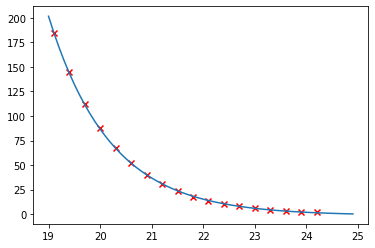

In [178]:
# Not going to worry too much about extrapolation of exponent: not relevant here
x_test = np.arange(19,25,0.1)
y_test = snrFit(x_test,m,t,b)
plt.plot(x_test,y_test)
plt.scatter(fors_mags,fors_snr, marker='x',color='red')
plt.show()

In [185]:
squaredDiffs = np.square(fors_snr - snrFit(fors_mags, m, t, b))
squaredDiffsFromMean = np.square(fors_snr - np.mean(fors_snr))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")
print("Y = %.4e * e^(-%.3f * x) + %.3f"%(m,t,b))

R² = 0.99989581245338
Y = 1.6368e+09 * e^(-0.837 * x) + -1.307


In [91]:
snr_list = []
for i in range(len(data_table)):
    snr_list.append(snrFit(data_table[i,2],m,t,b))

snr_list=np.array([snr_list])
data_table = np.append(data_table,np.transpose(snr_list),axis=1)

In [119]:
# Add magnitude uncertainties (1/SNR)
data_table = np.append(data_table, np.transpose([1./data_table[:,5]]), axis=1)

In [128]:
max(data_table[:,-1])

0.3885326223567217